# Setup

# Created By Alexander Cowen-Rivers 


In [10]:
import sys
sys.path.append('../Code/')
import matplotlib.pyplot as plt
import numpy as np
from collections import namedtuple
from utils import new_performance
import time
beginning_time = time.time()
import os
DATA_DIR = os.path.join('../..', 'Data')
import pandas as pd
np.set_printoptions(precision=3, suppress=1)
plt.style.use('seaborn-notebook')
def timtime(t):
    print(">",int(time.time()- t), "seconds elapsed")

In [11]:
# sparse might be important?

develop = False
        
train_X = pd.concat([pd.read_pickle(os.path.join(DATA_DIR, 'train_X_1')), 
                     pd.read_pickle(os.path.join(DATA_DIR, 'train_X_2'))])
train_y = pd.read_pickle(os.path.join(DATA_DIR, 'train_y'))
valid_X = pd.read_pickle(os.path.join(DATA_DIR, 'valid_X'))
valid_y = pd.read_pickle(os.path.join(DATA_DIR, 'valid_y'))
test_X = pd.read_pickle(os.path.join(DATA_DIR, 'test_X'))


In [12]:
# important columns

columns=[  1,   0,   4,   5,  47,   2,  58,  13,  49,  96,  10,  64, 671,
             24,   8,  23,   6, 106, 659,   3, 561, 723,   7,  74, 104, 818,
            132,  66,  16,  50, 658,  20,  11,  62,  12, 114, 806, 136, 128,
            654, 123,  59, 660,  81, 344,  48, 603, 126, 670, 124, 361, 656,
            536, 117, 116,  63, 724,  17, 133, 774]
           

In [13]:
if develop:
    train_X = train_X[0:10000]
    train_y = train_y[0:10000]
    valid_X = valid_X[0:10000]
    valid_y = valid_y[0:10000]

In [14]:
import pickle
pf = "../Models/tim_xgb_click.pkl"
with open(pf, 'rb') as file:
    GBDT = pickle.load(file)


In [15]:
from scipy.sparse import csr_matrix
train_X2 = csr_matrix(train_X) 
# valid_X = csr_matrix(valid_X) 

In [16]:
impression_values =GBDT.predict(train_X2)
del train_X2

In [17]:
np.sum(impression_values)

3042.8604

In [18]:
impression_values.shape

(2430981,)

In [19]:
#add budget feature 


In [20]:
#not included originally 

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(train_X)
train_X=scaler.transform(train_X)
# valid_X=scaler.transform(valid_X)
# test_X=scaler.transform(test_X)

In [21]:
train_y=train_y[:200000]

In [22]:
np.sum(train_y.click)

159

In [23]:
train_X=train_X[:200000,columns] #take 10% of training data 

In [24]:
buffer=np.zeros((train_X.shape[0],3), dtype=float) #budget consumption , total reward , time left


In [25]:
train_X.shape

(200000, 60)

In [26]:
train_X=np.append(train_X, buffer, axis=1)

In [27]:
train_X.shape

(200000, 63)

# Feature Grid world

In [19]:
#implement budget on the agent, initalise to 6250*1000

#@title FeatureGrid
class FeatureGrid(object):
    
    def __init__(self,feats,true_y,impression_values,verbose=False, discount=1.0,update_thresh=1e5,budget=6250*1000):
        
        self._start_state = (0)
        self._state = self._start_state
        self._number_of_states = feats.shape[0]
        self._discount=discount
        self.features=feats
        self.num_feats=feats.shape[1]
        self.true_y=true_y
        self.lambd_0=(1.0/75275.275275)
        self.lambd=(1.0/75275.275275)
        self.impression_values=impression_values
        self.fullbudget=budget
        self.budget=budget
        self.verbose=verbose
        self.all_actions=[-0.5,-0.15,-0.08,0,0.08,0.15,0.5]
        self.update_thresh=update_thresh
        self.totalreward=0
        self.totalr_regularizer=159
    def reset_budget(self):
        self.budget=self.fullbudget
    
    def step(self,action_int):
        
        #need to return reward,discount,nextstate, won_bid
        action=self.all_actions[int(action_int)]
#         if (self._state % self.update_thresh)==0: maybe do not need this to control lambda 
            
        
        self.lambd=(self.lambd_0+self.lambd_0*action) #lambda adjustment 
            
        
        bid=(self.impression_values[self._state]/self.lambd)
        pay=self.true_y.payprice[self._state]
        
        
        if (bid<=self.budget) and (bid>0):
        
            if pay < bid:

                won_bid = 1

            elif pay==bid: #if bid=bidprice then we pick randomly 

                won_bid=np.random.randint(2)

            else:

                won_bid=0

            if won_bid:
                self.budget=self.budget-pay #update budget consumption feature 
                r=self.impression_values[self._state]

            else:
                r=0

        else:
            r=0
            won_bid=0

        self.features[self._state+1,-3]=(self.budget/self.fullbudget)   #update budget left feature 
        self.totalreward+=(r*1.0/self.totalr_regularizer*1.0) #update total reward/ total achievable reward 
        self.features[self._state+1,-2]=self.totalreward*1.0 #update total reward
       
        self.features[self._state+1,-1]=(self._number_of_states*1.0-self._state*1.0)/self._number_of_states*1.0 #total time left ratio
        
#         if (self._state%100000)==0:
#             print("budget left",self.features[self._state+1,-3])
#             print("total r",self.totalreward)
#             print("time left",self.features[self._state+1,-1])
#             print("LAMBDA IS: ",self.lambd,"  ACTION WAS: ",action)

        
        next_s=self.features[self._state+1,:]
        self._state+=1
        discount=1
        if self.verbose:
            print("your bid was:  ",bid," and won_bid is =",won_bid)
            print("you paid: ",pay)
            print("state is: ",self._state)
            print("budget is: ",self.budget)
            print('total reward is',self.totalreward)
        
        clicks=self.true_y.click[self._state]*won_bid #if you got a click or not
        
        return r,discount,next_s,won_bid,clicks
    
    
    def get_obs(self):
        
        return self.features[self._state,:]
        
    

    def int_to_features(self, int_state):
        return self.features[int_state,:]

    def number_of_features(self):
        return self.num_feats
    
    def number_of_actions(self):
        return 7

In [20]:
#Test you can retrieve features 

feats=np.ones((10,10))
lables=np.ones((10,))
impression_vals=np.linspace(0.1,0.5,10)
# Instantiate the non tabular version of the environment.
feat_grid = FeatureGrid(feats,lables,impression_vals)
print("get features is:",feat_grid.int_to_features(1))
print("get number of features is:",feat_grid.number_of_features())
print("get number of actions is:",feat_grid.number_of_actions())

get features is: [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
get number of features is: 10
get number of actions is: 7


In [21]:
#advanced testing - step function 

feat_grid = FeatureGrid(train_X,train_y,impression_values,verbose=True)
print("######################")
print("###########TEST1###########")
print("step output is:",len(feat_grid.step(-0.5)))
print("######################")
print("###########TEST2###########")
print("reward output is:",feat_grid.step(-0.5)[0])
print("######################")
print("###########TEST3###########")
print("discount output is:",feat_grid.step(-0.5)[1])
print("######################")
print("###########TEST4###########")

print("next_s output is:",feat_grid.step(-0.5)[2].shape)

######################
###########TEST1###########
your bid was:   118.785315156  and won_bid is = 1
you paid:  5
state is:  1
budget is:  6249995
total reward is 4.96230303433e-06
step output is: 5
######################
###########TEST2###########
your bid was:   132.907257117  and won_bid is = 1
you paid:  23
state is:  2
budget is:  6249972
total reward is 1.05145557215e-05
reward output is: 0.000882808
######################
###########TEST3###########
your bid was:   87.8351198896  and won_bid is = 1
you paid:  24
state is:  3
budget is:  6249948
total reward is 1.41839022344e-05
discount output is: 1
######################
###########TEST4###########
your bid was:   135.298855826  and won_bid is = 1
you paid:  25
state is:  4
budget is:  6249923
total reward is 1.98360648938e-05
next_s output is: (63,)


In [34]:
def AdaptiveEpsilonGreedy(q,step,r=3e-7,verbose=False):
    
    #use 2e-3 as our dataset is 100 times smaller, thus 100 less steps 
    
    #dynamically changes epsilon as timesteps progress and as reward estimate changes 
    
    r=float(r)
    step=float(step)
    _epsilon=max(0.95-r*step,0.05)
    
    if verbose:
        print("_epsilon is:",_epsilon)
    if np.random.choice([1,0],p=[1-_epsilon,_epsilon]): 
        # if 1 then choose max action 
        return np.argmax(q)
    else: 
        # if 0 then choose random action 
        return np.random.randint(7)

In [35]:
q=np.linspace(0,300,11)
print("action taken after 20,000 steps is ",AdaptiveEpsilonGreedy(q,20000,verbose=True))

print("action taken after 100,000 steps is ",AdaptiveEpsilonGreedy(q,100000,verbose=True))
print("action taken after 200,000 steps is ",AdaptiveEpsilonGreedy(q,200000,verbose=True))
print("action taken 500,000 steps is ",AdaptiveEpsilonGreedy(q,500000,verbose=True))
print("action taken 1,000,000 steps is ",AdaptiveEpsilonGreedy(q,1000000,verbose=True))
print("action taken 1,500,000 steps is ",AdaptiveEpsilonGreedy(q,1500000,verbose=True))
print("action taken 2,000,000 steps is ",AdaptiveEpsilonGreedy(q,2000000,verbose=True))


_epsilon is: 0.944
action taken after 20,000 steps is  3
_epsilon is: 0.9199999999999999
action taken after 100,000 steps is  10
_epsilon is: 0.8899999999999999
action taken after 200,000 steps is  2
_epsilon is: 0.7999999999999999
action taken 500,000 steps is  2
_epsilon is: 0.6499999999999999
action taken 1,000,000 steps is  10
_epsilon is: 0.5
action taken 1,500,000 steps is  10
_epsilon is: 0.35
action taken 2,000,000 steps is  10


# Agents

In [36]:
from collections import defaultdict
from collections import deque
class RewardNet(object):

    def __init__(self, number_of_features, number_of_actions,step_size,max_steps):
        self.no_actions=number_of_actions
        self.number_of_features=number_of_features
        self._reward=np.zeros((number_of_actions,number_of_features))
        self.step_size=0.01 #change learning rate
        self.max_steps=max_steps
        self.replay_memory_size = 10000
        self.replaybuffer=deque([], maxlen=self.replay_memory_size)
        self.reward_memory=defaultdict(float)

        self.tempbuffer=deque([], maxlen=self.replay_memory_size)
        
    def reward(self, s, a):
        reward=np.dot(self._reward[a,:],s)
    
        return reward

    def transition(self, state, action):
        return self.reward(state, action)

    def update(self, state, action, reward,step_num,total_r):
        
        n=len(self.replaybuffer)
        total_r_adjusted=total_r/159 #R/R* where R* is the theoretical limit in the training program
        
        if n>1: #ensures on first iteration this does not get used 
            
            rand_int=np.random.randint(n)
            
            s,a,r=self.replaybuffer[rand_int]
            
            pred_q = np.dot(self._reward[a,:],s)

            dt=np.dot((pred_q-r),s.T)
            dt=np.clip(dt,-1,1)
            self._reward[a,:]=self._reward[a,:]-self.step_size*dt
        
            
        s=state
        a=action

        ################  Reward

        reward_act=reward
        
        self.tempbuffer.append((s,a))
        
        
        if (step_num==(self.max_steps-2)):
            print("Got to end ")
            for s,a in self.tempbuffer:
                
                a=np.array(a).reshape((-1,1))
                key=np.concatenate((s,a),axis=0)
                new_r=max(total_r_adjusted,self.reward_memory[str(key)])
                self.reward_memory[str(key)]=new_r
                self.replaybuffer.append((s,a,new_r))
                
            #reset temp buffer
            self.tempbuffer=deque([], maxlen=self.replay_memory_size)
            
        pass

In [37]:
class DRLB(object):

    def __init__(
          self, number_of_actions, initial_state, number_of_features,
          behaviour_policy, num_offline_updates=0, step_size=0.01,max_steps=0):


        self.number_of_features=number_of_features
        self.number_of_actions=number_of_actions
        self._state=initial_state
        self.behaviour_policy=behaviour_policy
        self.num_offline_updates=num_offline_updates
        self.step_size=step_size
        self.replay_memory_size = 10000
        self.replaybuffer=deque([], maxlen=self.replay_memory_size)
        self.params=np.zeros((number_of_actions,number_of_features))
        self._action=0
        self.replayerror=deque([], maxlen=self.replay_memory_size)
        
        self.params=np.zeros((number_of_actions,number_of_features))
        self._action=0
        self.RewardModel = RewardNet(self.number_of_features, self.number_of_actions,self.step_size,max_steps)
        self.max_steps=max_steps
        self.total_r=0
        
        pass
  

    def q(self, state):
        q_approx=np.dot(self.params,state)
    
        return q_approx
 
    def target_policy(self,state):
        #pick max action in state 
        return np.max(np.dot(self.params,state)) 
  
    def step(self, reward, discount, next_state,step_num,total_steps):   
        s = self._state.reshape(self.number_of_features,1)
        a = self._action
        r = reward
        self.total_r+=r
        g = discount
        next_s = next_state
        
        #Update RewardNet
        self.RewardModel.update(s,a,r,step_num,self.total_r) #update rewardnet
        self._action=a=self.behaviour_policy(self.q,total_steps) #take action at
        #get expected total episode reward from RewardNet
        r=self.RewardModel.transition(s,a) 
        self.replaybuffer.append((s,next_s,a,r)) #store s,next_s,a,r
        pred_q = np.dot(self.params[a,:],s)
        
        #Store TD error
        self.replayerror.append(np.sum(np.abs((pred_q-r))))
        
        #sample wrst TD error 
        n=len(self.replaybuffer)  
        self.num_offline_updates    
        replayprobs=self.replayerror/np.sum(self.replayerror)
        rand_int=np.random.choice(np.linspace(0,n-1,n,dtype=int),p=replayprobs)
        s,next_s,a,r=self.replaybuffer[rand_int]

        #gradient descent 
        reward_est=r+self.target_policy(next_state)
        pred_q = np.dot(self.params[a,:],s)
        dt=np.dot((pred_q-reward_est),s.T)
        dt=np.clip(dt,-1,1)
        self.params[a,:]=self.params[a,:]-self.step_size*dt
        self._state=next_state

        return self._action
    

In [ ]:
def step(self, reward, discount, next_state,step_num):   
    s = self._state.reshape(self.number_of_features,1)
    a = self._action
    r = reward
    self.total_r+=r
    g = discount
    next_s = next_state

    #Update RewardNet
    self.RewardModel.update(s,a,r,step_num,self.total_r) #update rewardnet
    self._action=a=self.behaviour_policy(self.q) #take action at
    
    #get expected total episode reward from RewardNet
    r=self.RewardModel.transition(s,a) 
    self.replaybuffer.append((s,next_s,a,r)) #store s,next_s,a,r
    pred_q = np.dot(self.params[a,:],s)

    #Store TD error
    self.replayerror.append(np.sum(np.abs((pred_q-r))))

    #sample wrst TD error 
    n=len(self.replaybuffer)  
    self.num_offline_updates    
    replayprobs=self.replayerror/np.sum(self.replayerror)
    rand_int=np.random.choice(np.linspace(0,n-1,n,dtype=int),p=replayprobs)
    s,next_s,a,r=self.replaybuffer[rand_int]

    #gradient descent 
    reward_est=r+self.target_policy(next_state)
    pred_q = np.dot(self.params[a,:],s)
    dt=np.dot((pred_q-reward_est),s.T)
    dt=np.clip(dt,-1,1)
    self.params[a,:]=self.params[a,:]-self.step_size*dt
    self._state=next_state

    return self._action




# Helper functions

In [38]:
from collections import defaultdict
from sklearn.utils import shuffle

def run_experiment(train_X,train_y,impression_values, number_of_iterations,number_of_steps,dyna=True,off_updates=0,budgets=6250*100,valid=False,agent_train=False,agent_in=True):
    
    action_count1=defaultdict(float)
    
    experiment_results=defaultdict(list)
    env=FeatureGrid(train_X,train_y,impression_values,budget=budgets) #reinitalise episode 
    
    agent = DRLB(
    number_of_features=env.number_of_features(), number_of_actions=env.number_of_actions(), initial_state=env.get_obs(),
    num_offline_updates=off_updates, step_size=0.1, behaviour_policy=AdaptiveEpsilonGreedy,max_steps=number_of_steps)
    
    else:
        agent=agent_train
    #returns mean rewards, need this to improve to show increase in performance
    # returns total won bids and won clicks
    all_rewards=[]
    won_bids_per_ep=[]
    clicks_per_ep=[]
    t=time.time()
    total_steps=0
    lamddaall=[]
    all_actions=[-0.5,-0.15,-0.08,0,0.08,0.15,0.5]
    for i in range(number_of_iterations):
        
        

        if (i%10)==0:
            print("Progress: {}% ".format(i*100/number_of_iterations))
            print(all_rewards,won_bids_per_ep,clicks_per_ep,action_count1)
            timtime(t)
            t=time.time()
            
        total_reward = 0.
        won_bids = 0. 
        won_clicks=0
        try:
            action = agent.initial_action()
        except AttributeError:
            action = 0
        for step in range(number_of_steps-1):
            action_count1[action]+=1
            lamddaall.append(all_actions[action])
            if env.budget<60: #ends episode if budget is low
                break
            reward, discount, next_state, won,clicks = env.step(action)
            
            action = agent.step(reward, discount, next_state,step,total_steps)
            total_steps+=1
            total_reward += reward
            
            won_bids+=won
            won_clicks += clicks
            
            
            
            
        all_rewards.append(total_reward)
        won_bids_per_ep.append(won_bids)
        clicks_per_ep.append(won_clicks)
        
        X_new, y_new = shuffle(train_X, train_y, random_state=0)
        env=FeatureGrid(X_new,y_new,impression_values,budget=budgets) #reinitalise episode for next run 
        
    return all_rewards,won_bids_per_ep,clicks_per_ep



    for i in range(number_of_episodes):
        action = agent.initial_action()
        for step in range(number_of_steps-1):
            
            #Terminates episode
            if AuctionEnv.budget<60: 
                break
            reward, discount, next_state = AuctionEnv.step(action)
            
            action = agent.step(reward, discount, next_state,step)
        
        #Shuffle data for stochasticity     
        X_new, y_new = shuffle(train_X, train_y)
        #Reinitalise enviroment for next episode 
        AuctionEnv=FeatureGrid(X_new,y_new,impression_values,budget=6250*10) 
        
  

In [39]:
steps=train_X.shape[0]

a=run_experiment(train_X,train_y,impression_values,number_of_iterations=1000,
                 number_of_steps=steps,dyna=False,off_updates=1)


Progress: 0.0% 
[] [] [] defaultdict(<class 'float'>, {})
> 0 seconds elapsed


/opt/Python/Python-3.6/lib/python3.6/site-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in true_divide
/opt/Python/Python-3.6/lib/python3.6/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in less


Progress: 1.0% 
[22.164606840990018, 22.128184203233104, 22.091994996240828, 21.459542220341973, 21.775672424410004, 21.673053835169412, 21.655711069935933, 21.593556522682775, 21.569976208906155, 21.577754347468726] [14082.0, 14043.0, 13996.0, 13886.0, 13832.0, 13780.0, 13771.0, 13699.0, 13695.0, 13710.0] [11, 11, 9, 13, 12, 13, 11, 12, 12, 14] defaultdict(<class 'float'>, {0: 54635.0, 6: 32826.0, 5: 32713.0, 3: 32730.0, 2: 32828.0, 1: 32940.0, 4: 32680.0})
> 1008 seconds elapsed
Progress: 2.0% 
[22.164606840990018, 22.128184203233104, 22.091994996240828, 21.459542220341973, 21.775672424410004, 21.673053835169412, 21.655711069935933, 21.593556522682775, 21.569976208906155, 21.577754347468726, 21.404172012698837, 21.003224508487619, 20.920742633345071, 20.978194013005123, 20.894503578019794, 20.752930175687652, 20.671524094592314, 20.503757407539524, 20.561816567904316, 20.520952537306584] [14082.0, 14043.0, 13996.0, 13886.0, 13832.0, 13780.0, 13771.0, 13699.0, 13695.0, 13710.0, 13598.

KeyboardInterrupt: 

In [ ]:
#try epsilon value of step rather than timestep 

# do I train with the click probabilities? or true click probs

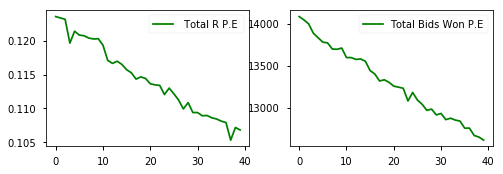

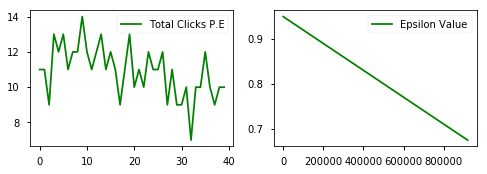

In [67]:
def plot_learning_curves(a,b):
    plt.figure()

    plt.subplot(2,2,1)
    plt.plot((np.divide(a[0],179.3)), 'g')
    plt.legend([' Total R P.E '])
    plt.subplot(2,2,2)
    plt.plot(a[1], 'g')
    plt.legend(['Total Bids Won P.E'])
    plt.figure()
    plt.subplot(2,2,1)
    plt.plot(a[2], 'g')
    plt.legend(['Total Clicks P.E'])
    plt.subplot(2,2,2)
    plt.plot(b, 'g')
    plt.legend(['Epsilon Value'])
    plt.show()
    
plot_learning_curves(a,alle)


In [42]:
import matplotlib.pyplot as plt

def plot_learning_curves(a):
    plt.figure()

    plt.subplot(1,3,1)
    plt.plot((np.divide(a[0],179.3)), 'g')
    plt.legend([' Total R P.E '])
    plt.subplot(1,3,2)
    plt.plot(a[1], 'g')
    plt.legend(['Total Bids Won P.E'])
    plt.subplot(1,3,3)
    plt.plot(a[2], 'g')
    plt.legend(['Total Clicks P.E'])
    plt.show()

In [ ]:
plot_learning_curves(a)
plt.savefig('SingleAgent.png')


$$\textbf{Single Agent - Dyna Q with linear approximation 
}$$ 


- Things left to implement:
- implement batches with Tensorflow 
- change to nonlinear 2 layers 50 neurons NN
- double q network


- currently uses memory replay with max memory size set to 10,000. 
- 1 experience replay per step, with regard to TD error
- uses 2e-5 parameter for modified greedy epsilon annealing rate
- has budget consumption as a feature. 
- has total predicted reward ratio.
- can change lambda each timestep.  
- Time left ratio. 
- clip gradients between -1 and 1. 
- implement reward dictionary in RewardNet, turns each state concated with action into a string as dict key. 
- linear regression to predict state,action,qvalues
- adjust total episode reward of R to be R/R* where R* is the theoretical best reward, set to be ~1800 which is the total number of clicks in the training set each with a reward of 1 if their impression value was one. 

$$\textbf{try this after training, make sure to record results}$$ 

- trained on smaller budget of 6250*10, in order to ensure total reward wasn't greater than 1 and also enough to see some clicks, should get between 1-2 clicks near convergence, 2 clicks maybe indicating 200 train set clicks

## Multi Agent

If single agent can coverge to a strategy, then implement two seperate agents on the market both DynaQ with the same impression values, see if they converge to a decent amount of click throughs. If not, maybe use a different impression value set 

In [ ]:
train_X.shape

In [ ]:
#implement budget on the agent, initalise to 6250*1000

#@title FeatureGrid
class MultiAgentGrid(object):
    
    def __init__(self,feats,true_y,impression_values,verbose=False, discount=1.0,update_thresh=1e5,budget=6250*1000):
        
        self._start_state = (0)
        self._state = self._start_state
        self._number_of_states = feats.shape[0]
        self._discount=discount
        self.features1=feats.copy()
        self.features2=feats.copy()
        self.num_feats=feats.shape[1]
        self.true_y=true_y
        
        self.lambd_1=(1.0/75275.275275)
        self.lambd1=(1.0/75275.275275)
        self.lambd_2=(1.0/80000)
        self.lambd2=(1.0/80000)
        
        self.impression_values=impression_values
        self.fullbudget=budget
        self.budget1=budget
        self.budget2=budget
        self.verbose=verbose
        self.all_actions1=[-0.5,-0.15,-0.08,0,0.08,0.15,0.5]
        self.all_actions2=[-0.75,-0.15,-0.08,0,0.08,0.15,0.75]

        self.update_thresh=update_thresh
        self.totalreward1=0
        self.totalreward2=0
        self.totalr_regularizer=159
        
        self.wonall1=0
        self.wonall2=0
    def reset_budget(self):
        self.budget=self.fullbudget
    
    def step(self,action_int1,action_int2):
        
        #need to return reward,discount,nextstate, won_bid
        action1=self.all_actions1[int(action_int1)]
        action2=self.all_actions2[int(action_int2)]
#         if (self._state % self.update_thresh)==0: maybe do not need this to control lambda 
            
        
        self.lambd1=(self.lambd_1+self.lambd_1*action1) #lambda adjustment 
        self.lambd2=(self.lambd_2+self.lambd_2*action2)    
        
        bid1=(self.impression_values[self._state]/self.lambd1)
        bid2=(self.impression_values[self._state]/self.lambd2)

        pay=self.true_y.payprice[self._state]
        
        #model1 wins 
        if (pay < bid1 )and (bid1<=self.budget1) and (bid1>bid2):
            won_bid1 = 1
            won_bid2 = 0 
            self.budget1=self.budget1-pay #update budget consumption feature 
            r1=self.impression_values[self._state]
            r2=0
            
        #model2 wins 
        elif (pay < bid2) and (bid2<=self.budget2) and (bid2>bid1):

            won_bid2 = 1
            won_bid1=0

            self.budget2=self.budget2-pay #update budget consumption feature 
            r2=self.impression_values[self._state]
            r1=0
        else: 
            
            r1=0
            won_bid1=0
            r2=0
            won_bid2=0
            
        self.features1[self._state+1,-3]=(self.budget1/self.fullbudget)   #update budget left feature 
        self.totalreward1+=(r1*1.0/self.totalr_regularizer*1.0) #update total reward/ total achievable reward 
        self.features1[self._state+1,-2]=self.totalreward1*1.0 #update total reward
        
        self.features2[self._state+1,-3]=(self.budget2/self.fullbudget)   #update budget left feature 
        self.totalreward2+=(r2*1.0/self.totalr_regularizer*1.0) #update total reward/ total achievable reward 
        self.features2[self._state+1,-2]=self.totalreward2*1.0 #update total reward
       
        self.features1[self._state+1,-1]=(self._number_of_states*1.0-self._state*1.0)/self._number_of_states*1.0 #total time left ratio
        self.features2[self._state+1,-1]=(self._number_of_states*1.0-self._state*1.0)/self._number_of_states*1.0 #total time left ratio

#         if (self._state%100000)==0:
#             print("budget left",self.features[self._state+1,-3])
#             print("total r",self.totalreward)
#             print("time left",self.features[self._state+1,-1])
#             print("LAMBDA IS: ",self.lambd,"  ACTION WAS: ",action)

        self.wonall1+=won_bid1
        self.wonall2+=won_bid2
        
        next_s1=self.features1[self._state+1,:]
        next_s2=self.features2[self._state+1,:]
        
        self._state+=1
        discount=1
        if self.verbose:
            print("your bid was:  ",bid," and won_bid is =",won_bid)
            print("you paid: ",pay)
            print("state is: ",self._state)
            print("budget is: ",self.budget)
            print('total reward is',self.totalreward)
        
        clicks1=self.true_y.click[self._state]*won_bid1 #if you got a click or not
        clicks2=self.true_y.click[self._state]*won_bid2 #if you got a click or not
        
        self.wonall1
        return r1,r2,next_s1,next_s2,won_bid1,won_bid2,clicks1,clicks2
   
    def get_obs(self):
        
        return self.features1[self._state,:]
        

    def int_to_features(self, int_state):
        return self.features[int_state,:]

    def number_of_features(self):
        return self.num_feats
    
    def number_of_actions(self):
        return 7

In [ ]:
from collections import defaultdict
from sklearn.utils import shuffle

def run_experiment_multi(train_X,train_y,impression_values, number_of_iterations,number_of_steps,budgets=6250*100,valid=False,agent_train=False,agent_in=True):
    
    
    action_count1=defaultdict(float)
    action_count2=defaultdict(float)

    experiment_results=defaultdict(list)
    env=MultiAgentGrid(train_X,train_y,impression_values,budget=budgets) #reinitalise episode 
    
    agent1 = DRLB(
    number_of_features=env.number_of_features(), number_of_actions=env.number_of_actions(), initial_state=env.get_obs(),
    num_offline_updates=0, step_size=0.1, behaviour_policy=AdaptiveEpsilonGreedy,max_steps=number_of_steps)
    
    agent2 = DRLB(
    number_of_features=env.number_of_features(), number_of_actions=env.number_of_actions(), initial_state=env.get_obs(),
    num_offline_updates=0, step_size=0.1, behaviour_policy=AdaptiveEpsilonGreedy,max_steps=number_of_steps)
    
    #returns mean rewards, need this to improve to show increase in performance
    # returns total won bids and won clicks
    all_rewards1=[]
    won_bids_per_ep1=[]
    clicks_per_ep1=[]
    all_rewards2=[]
    won_bids_per_ep2=[]
    clicks_per_ep2=[]
    t=time.time()
    total_steps=0
    for i in range(number_of_iterations):

        if ((i*100/number_of_iterations)%100) in [0,1]:
            print("Progress: {}% ".format(i*100/number_of_iterations))
            print(all_rewards1,all_rewards2,won_bids_per_ep1,won_bids_per_ep2,clicks_per_ep1,clicks_per_ep2)
            print("action_count1",action_count1)
            print("action_count2",action_count2)
            timtime(t)
            t=time.time()
        r1=0
        r2=0
        total_reward1 = 0.
        won_bids1 = 0. 
        won_clicks1=0
        
        total_reward2 = 0.
        won_bids2 = 0. 
        won_clicks2=0
        try:
            action1 = agent1.initial_action()
            action2 = agent2.initial_action()
        except AttributeError:
            action1 = 0
            action2 = 0
        for step in range(number_of_steps-1):
            
            if env.budget1<60 and env.budget2<60: #ends episode if budget is exhausted for both agents 
                break
            action_count1[action1]+=1
            action_count2[action2]+=1
            r1, r2, s1,s2, wn1,wn2,cl1,cl2 = env.step(action1,action2)
            
            #both agents select their action 
            
            action1 = agent1.step(r1, 1, s1,step,step)
            action2 = agent2.step(r2, 1, s2,step,step)
            total_steps+=1
            total_reward1 += r1
            total_reward2 += r2
            
            won_bids1+=wn1
            won_clicks1 += cl1
            
            won_bids2+=wn2
            won_clicks2 += cl2
            
        all_rewards1.append(total_reward1)
        won_bids_per_ep1.append(won_bids1)
        clicks_per_ep1.append(won_clicks1)
        
        all_rewards2.append(total_reward2)
        won_bids_per_ep2.append(won_bids2)
        clicks_per_ep2.append(won_clicks2)
        
        X_new, y_new = shuffle(train_X, train_y, random_state=0)
        env=MultiAgentGrid(X_new,y_new,impression_values,budget=budgets) #reinitalise episode for next run 
        
    return all_rewards1,won_bids_per_ep1,clicks_per_ep1,all_rewards2,won_bids_per_ep2,clicks_per_ep2


In [ ]:
run_experiment_multi(train_X,train_y,impression_values,number_of_iterations=1000,number_of_steps=steps,budgets=6250*100)

In [ ]:
print("mean normalised total reward from ag1 & ag2 is:",np.mean(np.divide(a[0],179.3)),np.mean(np.divide(a[1],179.3)))

In [7]:
a=[[19.405071293469518, 19.198033080028836, 17.71502615098143, 18.559376090299338, 17.665040362626314, 17.679279721400235, 18.728713624645025, 19.287618351983838, 18.895503391744569, 19.874820836645085, 19.190996444027405, 20.020858450559899, 18.321512830967549, 17.5123784202151, 20.116654705139808, 18.651724969851784, 18.304144711059052, 17.787923350639176, 19.197078393946867, 17.515040475642309, 18.632651923107915, 17.095053714467213, 18.872664176451508, 17.369952731649391, 18.376007371291053, 19.352183053502813, 18.355584149423521, 20.648936908575706, 20.470346002664883, 19.582851851882879, 17.690689702983946, 20.186985497595742, 17.867663485638332, 18.00905843207147, 17.537936310633086, 17.398720632656477, 19.252024191431701, 16.929198029916734, 18.524980262794998, 18.382667830155697, 16.629900526371785, 18.299110094434582, 18.615283667400945, 20.393580893811304, 19.859524857543875, 20.491240972594824, 17.092475125915371, 18.41821935743792, 19.170491978700738, 19.469718195381574, 18.580444892577361, 16.899934615881648, 18.641618457157165, 18.622977471735794, 18.737266698852181, 19.988130560610443, 19.40531330590602, 19.443915669980925, 19.139878457644954, 17.357289792736992, 18.49442070123041, 18.37046138982987, 18.355817166098859, 19.641435414727312, 21.026801677420735, 16.691526123846415, 17.888705920428038, 17.927041089569684, 18.772975872561801, 18.638653084926773, 17.391564151679631, 18.758677667705342, 17.719366185658146, 18.082978528458625, 17.867729134042747, 18.84508258808637, 19.371380753116682, 18.842426983057521, 19.734087593154982, 17.997951660247054, 19.381797470967285, 18.887505501625128, 18.58814544568304, 17.6295758462511, 18.860319104685914, 17.687617041927297, 19.632487610448152, 18.949943623098079, 17.742825424997136, 20.978774132905528, 20.165276357263792, 18.76419102307409, 18.035500171012245, 18.754435695242137, 17.906374892336316, 17.264482863945886, 17.388551692129113, 18.874350866768509, 20.03518555482151, 17.396193967899308] ,[14.677394758211449, 13.701629292278085, 14.884117439389229, 15.798856054781936, 14.340673932339996, 15.221238608006388, 13.869307952176314, 13.741718450619373, 14.167237948975526, 13.618814218032639, 15.505477432860062, 14.159121445205528, 14.214470620499924, 15.382942765776534, 14.419299007044174, 14.597869330493268, 14.406591818085872, 15.622411320277024, 14.565729914582334, 14.718329876719508, 14.477419221075252, 16.244891388574615, 13.219023762037978, 15.304125638096593, 14.279966874106321, 14.414201914099976, 14.647301472141407, 13.083191644866019, 13.769408659776673, 13.593121946032625, 15.162920133327134, 13.235987564781681, 15.233184319164138, 14.352765408693813, 14.744007822533604, 15.619032152055297, 13.758786635706201, 15.971097040572204, 14.146241526701488, 14.411490313184913, 15.570790599042084, 14.652265477285255, 14.317815335467458, 12.652826980745886, 13.877892377728131, 13.375839308428112, 15.815637432271615, 14.663825981144328, 14.542147631873377, 14.157332619361114, 14.681482976360712, 15.681969633384142, 14.369948256353382, 14.23182160477154, 15.432185107492842, 13.447913218056783, 14.338614666543435, 13.694597308698576, 14.088536023919005, 15.276489979121834, 14.686886459123343, 14.044153248774819, 15.440190921304747, 14.458428924379405, 13.308572924288455, 16.143575893889647, 14.66438929294236, 14.451247236924246, 14.41724800405791, 14.439719599380624, 15.275311931909528, 14.773483374214265, 15.061717033968307, 14.792366038600449, 15.132861999503803, 14.39800429425668, 14.274740226275753, 14.139950253767893, 14.209607758792117, 14.773364850145299, 13.175943279871717, 13.863850827328861, 14.189011973387096, 14.90370572876418, 14.18062190967612, 15.293609405111056, 13.76290991040878, 14.271117368596606, 15.112694646581076, 13.552369329147041, 14.395144959737081, 14.211307189543732, 14.549180718255229, 15.017757841444109, 15.631634727702476, 14.625010346411727, 16.175998071790673, 13.929971086035948, 14.136539725703187, 15.664704624097794], [12726.0, 12769.0, 12697.0, 12855.0, 12722.0, 12687.0, 12699.0, 12670.0, 12669.0, 12859.0, 12803.0, 12740.0, 12795.0, 12702.0, 12771.0, 12693.0, 12572.0, 12680.0, 12723.0, 12777.0, 12536.0, 12674.0, 12662.0, 12747.0, 12698.0, 12726.0, 12837.0, 12756.0, 12744.0, 12658.0, 12667.0, 12730.0, 12692.0, 12777.0, 12598.0, 12645.0, 12779.0, 12553.0, 12590.0, 12776.0, 12681.0, 12573.0, 12678.0, 12636.0, 12774.0, 12611.0, 12674.0, 12689.0, 12782.0, 12699.0, 12692.0, 12794.0, 12765.0, 12739.0, 12718.0, 12672.0, 12711.0, 12567.0, 12784.0, 12710.0, 12776.0, 12635.0, 12719.0, 12832.0, 12711.0, 12756.0, 12739.0, 12690.0, 12753.0, 12719.0, 12709.0, 12716.0, 12689.0, 12701.0, 12772.0, 12774.0, 12732.0, 12697.0, 12623.0, 12704.0, 12617.0, 12709.0, 12642.0, 12733.0, 12781.0, 12691.0, 12682.0, 12678.0, 12733.0, 12587.0, 12650.0, 12717.0, 12792.0, 12732.0, 12731.0, 12783.0, 12633.0, 12771.0, 12624.0, 12684.0] ,[10470.0, 10532.0, 10434.0, 10438.0, 10381.0, 10471.0, 10456.0, 10436.0, 10437.0, 10454.0, 10446.0, 10440.0, 10505.0, 10468.0, 10375.0, 10457.0, 10385.0, 10531.0, 10371.0, 10446.0, 10506.0, 10506.0, 10416.0, 10429.0, 10538.0, 10485.0, 10522.0, 10435.0, 10423.0, 10527.0, 10579.0, 10352.0, 10510.0, 10415.0, 10477.0, 10498.0, 10514.0, 10559.0, 10440.0, 10287.0, 10412.0, 10463.0, 10496.0, 10513.0, 10470.0, 10488.0, 10467.0, 10532.0, 10433.0, 10480.0, 10445.0, 10432.0, 10469.0, 10501.0, 10513.0, 10596.0, 10496.0, 10442.0, 10485.0, 10522.0, 10398.0, 10533.0, 10556.0, 10424.0, 10468.0, 10413.0, 10360.0, 10480.0, 10394.0, 10467.0, 10446.0, 10398.0, 10452.0, 10430.0, 10412.0, 10519.0, 10545.0, 10414.0, 10555.0, 10362.0, 10501.0, 10591.0, 10486.0, 10479.0, 10491.0, 10486.0, 10365.0, 10534.0, 10511.0, 10514.0, 10532.0, 10500.0, 10378.0, 10370.0, 10393.0, 10427.0, 10506.0, 10432.0, 10634.0, 10494.0] ,[6, 10, 9, 9, 8, 7, 8, 7, 10, 11, 5, 9, 12, 14, 8, 6, 9, 10, 9, 5, 7, 10, 6, 14, 10, 7, 9, 11, 9, 5, 11, 10, 6, 9, 5, 9, 5, 16, 6, 11, 8, 11, 9, 7, 11, 11, 8, 9, 6, 8, 7, 8, 12, 8, 9, 10, 13, 13, 12, 6, 11, 11, 7, 11, 9, 5, 5, 11, 10, 8, 12, 8, 13, 7, 13, 7, 8, 13, 5, 8, 9, 10, 9, 9, 6, 8, 7, 9, 8, 8, 12, 10, 12, 6, 12, 10, 8, 11, 8, 9] ,[10, 5, 10, 9, 8, 9, 7, 13, 7, 7, 14, 9, 8, 4, 8, 11, 9, 10, 9, 12, 7, 5, 10, 8, 7, 9, 9, 7, 8, 12, 7, 9, 9, 8, 9, 13, 12, 7, 9, 7, 10, 7, 7, 11, 7, 12, 10, 8, 12, 11, 9, 9, 8, 7, 9, 9, 6, 7, 9, 12, 8, 6, 13, 6, 8, 11, 11, 9, 10, 7, 8, 10, 8, 10, 7, 12, 10, 7, 10, 9, 10, 8, 9, 5, 12, 12, 14, 9, 10, 11, 4, 8, 6, 10, 9, 10, 8, 7, 13, 9]]

In [8]:
import matplotlib.pyplot as plt

def plot_learning_curves(a):
    plt.figure()

    plt.subplot(1,3,1)
    plt.plot((np.divide(a[0],179.3)), 'b')
    plt.plot((np.divide(a[1],179.3)), 'g')
    plt.legend([' Total R P.E '])
    plt.subplot(1,2,2)
    plt.plot(a[2], 'b')
    plt.plot(a[3], 'g')
    plt.legend(['Total Bids Won P.E'])
    plt.figure()
    plt.plot(a[4], 'b')
    plt.plot(a[5], 'g')
    plt.legend(['Total Clicks P.E'])
    plt.show()

#Simplified training process for report 

for i in range(number_of_episodes):
    action1 = agent1.initial_action()
    action2 = agent2.initial_action()
    for step in range(number_of_steps-1):

        #Terminates episode
        if AuctionEnv.budget1<60 and AuctionEnv.budget2<60:  
            break

        r1, r2, nxt_s1,nxt_s2 = AuctionEnv.step(action1,action2)

        #both agents select their action 

        action1 = agent1.step(r1, 1, nxt_s1,step)
        action2 = agent2.step(r2, 1, nxt_s2,step)

    #Shuffle data for stochasticity     
    X_new, y_new = shuffle(train_X, train_y)
    #Reinitalise enviroment for next episode 
    AuctionEnv=MultiAgentGrid(X_new,y_new,impression_values,budget=6250*10) 
    
    

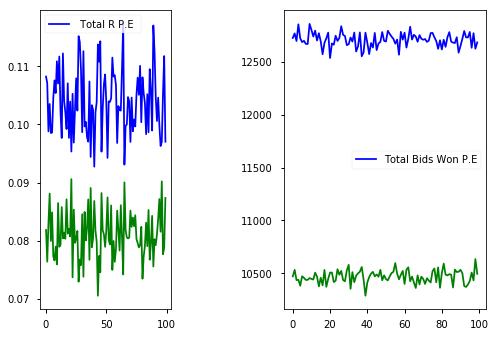

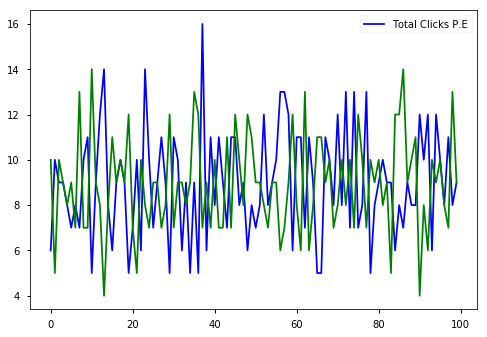

In [9]:
plot_learning_curves(a)

In [ ]:
ag1_ac=[1024364.0, 587956.0, 588409.0, 587591.0, 587756.0, 588567.0, 588599.0]
ag2_ac=[1022871.0, 588523.0, 589072.0, 589828.0, 586616.0, 587894.0, 588438.0]


In [ ]:
ag2_probs

In [ ]:
ag1_probs


In [ ]:
ag2_probs=np.divide(ag2_ac,np.sum(ag2_ac))
ag1_probs=np.divide(ag1_ac,np.sum(ag1_ac))

In [ ]:
def plot_action_curves(a1,a2):
    plt.figure()
    plt.plot([1,2,3,4,5,6,7],a1, 'b-')
    plt.plot([1,2,3,4,5,6,7],a2, 'g')
    plt.axis([1,7,0,0.3])
    plt.legend([' Action Selection Probabilities '])
    plt.show()

In [ ]:
plot_action_curves(ag1_probs,ag2_probs)